In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


#### Set hyperparameter

In [ ]:
# set hyperparameter
EPOCH = 1
BATCH_SIZE = 50
LEARN_RATE = 0.001
DOWNLOAD_MNIST = True

#### Download MNIST data

In [ ]:
# Transform
transform = torchvision.transforms.ToTensor()

train_data = torchvision.datasets.MNIST(
    root = './mnist',
    train = True,
    transform = transform,
    download=DOWNLOAD_MNIST
)

print('train data size = ', train_data.train_data.size()[0])
print('train label size = ', train_data.train_labels.size()[0])
print('input image shape = ', list(train_data.train_data[0].size()))
print('---')


test_data = torchvision.datasets.MNIST(
    root = './mnist/',
    train = False,
    transform = transform,
    download=DOWNLOAD_MNIST
)
print('test data size = ', test_data.test_data.size()[0])
print('test label size = ', test_data.test_data.size()[0])
print('---')

100%|██████████| 9912422/9912422 [00:00<00:00, 92771864.88it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 93181302.94it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24475919.71it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5259671.11it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw

train data size =  60000
train label size =  60000
input image shape =  [28, 28]
---
test data size =  10000
test label size =  10000
---


/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


#### Check MNIST image

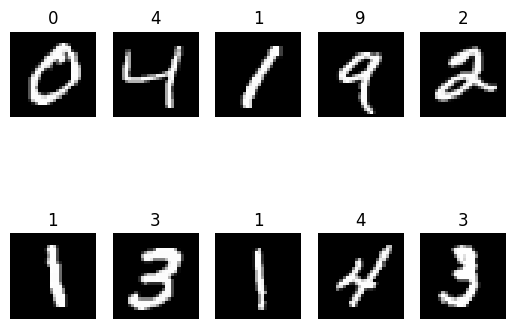

In [ ]:
plt.ion()
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(train_data.train_data[i].numpy(), cmap = 'gray')
    plt.axis('off')
    plt.title('%i' % train_data.train_labels[i])
plt.show()

#### Build CNN Module (LeNet)

In [ ]:
class LeNet(nn.Module):
    def __init__(self, in_channel_num = 1, out_class_num = 10):
        super(LeNet, self).__init__()
        self.feature_maps = list()
        # conv1: 28x28x1 -> 28x28x6 -> 14x14x6
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = in_channel_num, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # conv2: 14x14x6 -> 10x10x16 -> 5x5x16
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # full connection: 5x5x16 -> 120 -> 84 -> 10
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=out_class_num)

    def forward(self, x):
        self.feature_maps.clear()
        x = self.conv1(x)
        self.feature_maps.append(x)
        x = self.conv2(x)
        self.feature_maps.append(x)
        x = torch.flatten(x, 1)
        self.feature_maps.append(x)
        x = F.relu(self.fc1(x))
        self.feature_maps.append(x)
        x = F.relu(self.fc2(x))
        self.feature_maps.append(x)
        x = self.fc3(x)
        print(self.feature_maps)
        return x

#### Initialize CNN Model
- model : LeNet
- optimization function : Adam
- loss function : Cross Entropy

In [ ]:
model = LeNet()
optimization = torch.optim.Adam(model.parameters(), lr = LEARN_RATE)
loss_func = nn.CrossEntropyLoss()

print(model)
print('---')

# calculate number of total parameters
total_param_num = 0
for parameter in model.parameters():
    # print(parameter.size())
    param_num=1
    for s in list(parameter.size()):
        param_num = param_num*s
    total_param_num += param_num
print('# of parameters = ', total_param_num)

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
---
# of parameters =  61706


#### Start Training

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size=BATCH_SIZE, shuffle = False)

In [ ]:
from torch.autograd import Variable

model.to(device)
for epoch in range(EPOCH):
    model.train()
    train_loss = 0
    train_correct_count = 0
    train_count = 0
    for step, (batch_x, batch_y) in enumerate(train_loader):
        bx = Variable(batch_x).to(device)
        by = Variable(batch_y).to(device)

        # Forward propagation
        output = model(bx)
        loss = loss_func(output, by)

        # Clear gradient
        optimization.zero_grad()
        # Calculate gradients
        loss.backward()
        # Calculate gradients
        optimization.step()

        train_loss += loss.item()
        train_count += len(by)
        train_correct_count += sum((output.argmax(1) == by))

        if (step+1) % 100 == 0:
            accuracy = train_correct_count / train_count
            loss = train_loss / (step+1)
            print('Epoch: ', epoch, ' | iter: %4d / %4d' % (step+1, len(train_loader)), ' | train loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)
    print('---')

Epoch:  0  | iter:  100 / 1200  | train loss: 1.1891 | test accuracy: 0.62
Epoch:  0  | iter:  200 / 1200  | train loss: 0.7993 | test accuracy: 0.75
Epoch:  0  | iter:  300 / 1200  | train loss: 0.6276 | test accuracy: 0.80
Epoch:  0  | iter:  400 / 1200  | train loss: 0.5226 | test accuracy: 0.84
Epoch:  0  | iter:  500 / 1200  | train loss: 0.4531 | test accuracy: 0.86
Epoch:  0  | iter:  600 / 1200  | train loss: 0.4051 | test accuracy: 0.87
Epoch:  0  | iter:  700 / 1200  | train loss: 0.3685 | test accuracy: 0.89
Epoch:  0  | iter:  800 / 1200  | train loss: 0.3387 | test accuracy: 0.89
Epoch:  0  | iter:  900 / 1200  | train loss: 0.3144 | test accuracy: 0.90
Epoch:  0  | iter: 1000 / 1200  | train loss: 0.2936 | test accuracy: 0.91
Epoch:  0  | iter: 1100 / 1200  | train loss: 0.2766 | test accuracy: 0.91
Epoch:  0  | iter: 1200 / 1200  | train loss: 0.2628 | test accuracy: 0.92
---


#### Start Testing

In [ ]:
model.to(device)
torch.no_grad()

test_loss = 0
test_correct_count = 0
test_count = 0
for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(test_loader):
        bx = Variable(batch_x).to(device)
        by = Variable(batch_y).to(device)

        # Forward propagation
        output = model(bx)
        loss = loss_func(output, by)

        test_loss += loss.item()
        test_count += len(by)
        test_correct_count += sum(output.argmax(1) == by)

accuracy = test_correct_count / test_count
loss = test_loss / (len(test_loader) * EPOCH)
print('test loss: %.4f' % loss, '| test accuracy: %.2f' % accuracy)

test loss: 0.0801 | test accuracy: 0.97


golden answer [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4]
your answer   [7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4]
correctess =  100 %


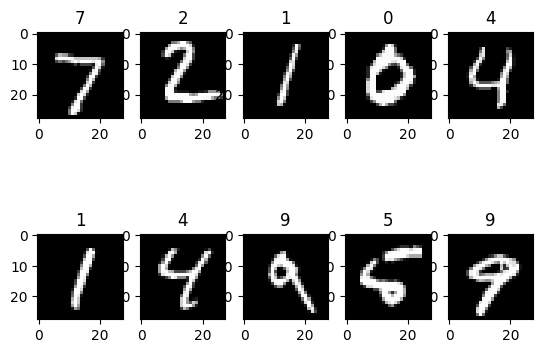

In [ ]:
plt.ion()
model.to('cpu')
for _, (batch_x, batch_y) in enumerate(test_loader):
    bx = Variable(batch_x)
    by = Variable(batch_y)
    output = model(bx).argmax(1)
    print('golden answer', list(by.numpy()))
    print('your answer  ', list(output.numpy()))
    print('correctess = ', sum((output == by)).numpy() * 2, '%')

    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(bx[i][0].numpy(), cmap = 'gray')
        plt.title('%d' % output[i])
    break

plt.show()

#### Write Parameters file and Inputs file

In [ ]:
# Print model's state_dict
model.to('cpu')
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv1.0.weight 	 torch.Size([6, 1, 5, 5])
conv1.0.bias 	 torch.Size([6])
conv2.0.weight 	 torch.Size([16, 6, 5, 5])
conv2.0.bias 	 torch.Size([16])
fc1.weight 	 torch.Size([120, 400])
fc1.bias 	 torch.Size([120])
fc2.weight 	 torch.Size([84, 120])
fc2.bias 	 torch.Size([84])
fc3.weight 	 torch.Size([10, 84])
fc3.bias 	 torch.Size([10])


In [ ]:
f = open("weight.txt", "w")
for param_tensor in model.state_dict():
    # calculate parameter size
    param_size = 1
    size = list(model.state_dict()[param_tensor].size())
    for s in size:
        param_size *= s
    # modify parameter name
    name = param_tensor.split('.')
    name = name[0] + '_' + name[-1]
    # write file
    f.write('%s %d\n' % (name, param_size))
    weights = model.state_dict()[param_tensor]
    weights = torch.flatten(weights).tolist()
    for i in weights:
        f.write(str(i) + ' ')
    f.write('\n')
f.close()

In [ ]:
fin = open("input.txt", "w")
fout = open("golden_output.txt", "w")
padding = nn.ZeroPad2d(2)
model.to('cpu')

fin.write("1024 1 10\n")
for _, (batch_x, batch_y) in enumerate(test_loader):
    bx = Variable(batch_x)
    by = Variable(batch_y)

    for i in range(BATCH_SIZE):
        padding_bx = padding(bx[i])
        input_img = torch.flatten(padding_bx).tolist()
        cnt = 0
        for pixel in input_img:
            fin.write(str(pixel) + ' ')
            cnt += 1
            if cnt % 32 == 0:
                fin.write('\n')
        fout.write('%d\n' % int(by[i]))
    break

fin.close()
fout.close()